In [39]:
# Standard
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../")))
import config
import json
from collections import defaultdict
import pandas as pd 
import numpy as np
import random
import sqlite3

# Plotting
import matplotlib.pyplot as plt

# Types (optional for type hints)
from typing import List

# Your SubGraph class (assume already defined/imported)
from SubGraph import SubGraph  # Replace with actual path/module if needed


In [40]:
# Load a list of SubGraphs from a JSONL file
def load_subgraphs_from_jsonl(filepath: str) -> List[SubGraph]:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [SubGraph(**json.loads(line)) for line in lines]

subgraphs = load_subgraphs_from_jsonl("../"+config.SUBGRAPHS_JSONL)
print(f"Loaded {len(subgraphs)} subgraphs.")


Loaded 5888 subgraphs.


In [51]:
def plot_fact_count_distribution(subgraphs: List[SubGraph], bins: int = 100, min_number = 10):
    """
    Plots a histogram showing how many facts each SubGraph contains,
    excluding subgraphs with 0 facts (but reports how many were skipped).

    Args:
        subgraphs: List of SubGraph objects.
        bins: Number of bins for the histogram.
    """
    fact_counts = [sg.fact_count for sg in subgraphs]
    print(f"Largest subgraph has {max(fact_counts)} facts.")
    
    # Filter out subgraphs with 0 facts
    nonzero_counts = [c for c in fact_counts if c > 0]
    reasonable_counts = [c for c in nonzero_counts if c < 200]  # Exclude outliers for better visualization
    ready_graphs = len([c for c in fact_counts if c >= min_number])
    print(f"Number of subgraphs with at least {min_number} facts: {ready_graphs}")
    zero_count = len(fact_counts) - len(nonzero_counts)
    large_count = len(nonzero_counts) - len(reasonable_counts)
    print(f"Number of subgraphs with 0 facts: {zero_count}")
    print(f"Number of subgraphs with >100 facts: {large_count}")

    plt.figure(figsize=(8, 5))
    plt.hist(reasonable_counts, bins=bins, edgecolor='black', color='steelblue')
    
    plt.xlabel("Number of Facts per SubGraph")
    plt.ylabel("Number of SubGraphs")
    plt.title("Distribution of Fact Counts (Excluding 0 or Large Counts)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mention how many 0-fact subgraphs were excluded
    plt.legend([f"{zero_count} subgraphs with 0 facts excluded"])
    if large_count > 0:
        plt.legend([f"{zero_count} subgraphs with 0 facts excluded", 
                    f"{large_count} subgraphs with >1000 facts excluded"])
    
    plt.tight_layout()
    plt.show()



Largest subgraph has 1982 facts.
Number of subgraphs with at least 10 facts: 2896
Number of subgraphs with 0 facts: 972
Number of subgraphs with >100 facts: 155


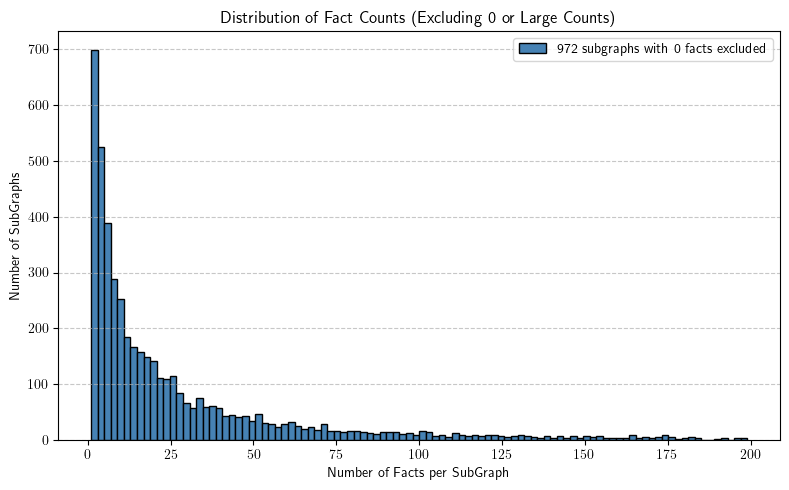

In [52]:
plot_fact_count_distribution(subgraphs)

In [53]:
def plot_valid_subgraphs_per_ticker(subgraphs: List[SubGraph], min_facts: int = 5):
    """
    Plots how many valid SubGraphs each ticker has (valid = fact_count >= min_facts).
    Includes all tickers from the metadata file, even those with 0 valid subgraphs.
    """

    # Step 1: Load all tickers from metadata CSV
    metadata = pd.read_csv("../" + config.METADATA_CSV_FILEPATH)
    all_tickers = metadata["Symbol"].dropna().astype(str).unique()

    # Step 2: Count valid subgraphs per ticker
    ticker_counts = defaultdict(int)
    for sg in subgraphs:
        try:
            if getattr(sg, "fact_count", 0) >= min_facts:
                ticker = getattr(sg, "primary_ticker", None)
                if ticker:
                    ticker_counts[str(ticker)] += 1
        except Exception:
            continue

    # Step 3: Fill missing tickers with 0
    full_counts = {ticker: ticker_counts.get(ticker, 0) for ticker in all_tickers}

    # Step 4: Sort for nicer plotting
    sorted_items = sorted(full_counts.items(), key=lambda x: x[1], reverse=True)
    tickers, counts = zip(*sorted_items) if sorted_items else ([], [])

    # Print total number of valid subgraphs
    total_valid = sum(counts)
    print(f"Total valid subgraphs with ≥{min_facts} facts: {total_valid}")

    # Step 5: Plot (force-disable LaTeX locally to avoid usetex errors)
    with plt.rc_context({"text.usetex": False}):
        x = np.arange(len(tickers))
        bar_width = 0.6

        plt.figure(figsize=(max(10, len(tickers) * 0.5), 6))
        plt.bar(x, counts, width=bar_width, edgecolor="black")
        plt.xticks(ticks=x, labels=tickers, rotation=45, ha="right")

        if len(x) > 0:
            plt.xlim(x[0] - bar_width / 2, x[-1] + bar_width / 2)

        plt.xlabel("Ticker")
        plt.ylabel(f"Number of SubGraphs with ≥{min_facts} Facts")
        plt.title("Valid SubGraphs per Ticker (Including Zeros)")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Optional: keep the raw counts visible in the notebook
    print(sorted_items)


Total valid subgraphs with ≥10 facts: 2896


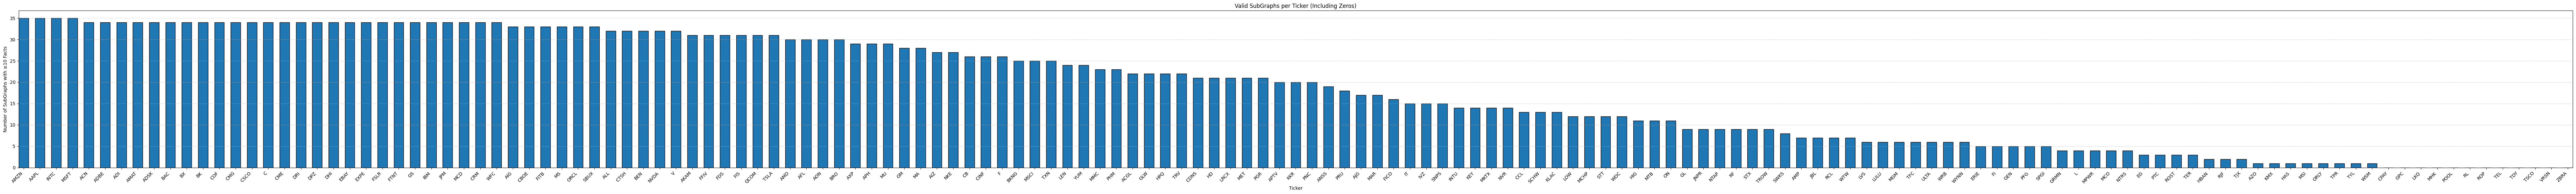

[('AMZN', 35), ('AAPL', 35), ('INTC', 35), ('MSFT', 35), ('ACN', 34), ('ADBE', 34), ('ADI', 34), ('AMAT', 34), ('ADSK', 34), ('BAC', 34), ('BX', 34), ('BK', 34), ('COF', 34), ('CMG', 34), ('CSCO', 34), ('C', 34), ('CME', 34), ('DRI', 34), ('DPZ', 34), ('DHI', 34), ('EBAY', 34), ('EXPE', 34), ('FSLR', 34), ('FTNT', 34), ('GS', 34), ('IBM', 34), ('JPM', 34), ('MCD', 34), ('CRM', 34), ('WFC', 34), ('AIG', 33), ('CBOE', 33), ('FITB', 33), ('MS', 33), ('ORCL', 33), ('SBUX', 33), ('ALL', 32), ('CTSH', 32), ('BEN', 32), ('NVDA', 32), ('V', 32), ('AKAM', 31), ('FFIV', 31), ('FDS', 31), ('FIS', 31), ('QCOM', 31), ('TSLA', 31), ('AMD', 30), ('AFL', 30), ('AON', 30), ('BRO', 30), ('AXP', 29), ('APH', 29), ('MU', 29), ('GM', 28), ('MA', 28), ('AIZ', 27), ('NKE', 27), ('CB', 26), ('CINF', 26), ('F', 26), ('BKNG', 25), ('MSCI', 25), ('TXN', 25), ('LEN', 24), ('YUM', 24), ('MMC', 23), ('PHM', 23), ('ACGL', 22), ('GLW', 22), ('HPQ', 22), ('TRV', 22), ('CDNS', 21), ('HD', 21), ('LRCX', 21), ('MET', 21)

In [55]:
plot_valid_subgraphs_per_ticker(subgraphs, min_facts=10)

In [45]:
def plot_car_triptych(
    subgraph_a,
    subgraph_b,
    subgraph_c,
    pre_event_days: int = 20,
    post_event_days: int = 60,
    early_window_days: int = 15,   # start_offset_days
    benchmark_ticker: str = "SPY",
    use_latex: bool = True,
    save_path: str | None = None
):
    """
    Plot CAR (ticker minus benchmark log-returns) for three events side-by-side.
    - Short window shaded: [0, early_window_days]
    - Medium window shaded: [early_window_days, post_event_days]
    - Dotted trend in medium window computed EXACTLY like calculate_label (x=0..N-1 on CAR segment)
    - Extra subtle dotted trend for overall post-earnings window [0, post_event_days]
    """
    import os
    import sqlite3
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import config

    if use_latex:
        plt.rcParams["text.usetex"] = True

    rel_idx = np.arange(-pre_event_days, post_event_days + 1)

    def _extract(sg):
        # Accept dicts or SubGraph-like objects
        if isinstance(sg, dict):
            tkr = str(sg["primary_ticker"]).upper()
            dt  = pd.to_datetime(sg["reported_date"])
            eps = sg.get("eps_surprise", None)
            lab = sg.get("label", None)
        else:
            tkr = str(getattr(sg, "primary_ticker")).upper()
            dt  = pd.to_datetime(getattr(sg, "reported_date"))
            eps = getattr(sg, "eps_surprise", None)
            lab = getattr(sg, "label", None)
        return tkr, dt, eps, lab

    def _compute_item(sg):
        try:
            ticker, er_date, eps_surprise, label = _extract(sg)
        except Exception:
            return None

        # Fetch enough prices
        fetch_start = (er_date - pd.Timedelta(days=120)).strftime("%Y-%m-%d")
        fetch_end   = (er_date + pd.Timedelta(days=180)).strftime("%Y-%m-%d")

        def fetch_prices(sym: str) -> pd.DataFrame:
            q = f"""
                SELECT date, adjusted_close
                FROM {config.PRICING_TABLE_NAME}
                WHERE ticker = ? AND date BETWEEN ? AND ?
                ORDER BY date ASC;
            """
            with sqlite3.connect("../" + config.DB_PATH) as conn:
                df = pd.read_sql_query(q, conn, params=(sym, fetch_start, fetch_end))
            if df.empty:
                return df
            df["date"] = pd.to_datetime(df["date"])
            df = df.sort_values("date").rename(columns={"adjusted_close": "px"}).reset_index(drop=True)
            return df

        df_t = fetch_prices(ticker)
        df_b = fetch_prices(benchmark_ticker)
        if df_t.empty or df_b.empty:
            return None

        # Align and locate event index (first trading day >= report date)
        df = pd.merge(df_t, df_b, on="date", how="inner", suffixes=("_t", "_b"))
        if df.empty or len(df) < 3:
            return None

        pos = df.index[df["date"] >= er_date]
        if len(pos) == 0:
            return None
        e_idx = int(pos[0])

        # Ensure coverage
        if e_idx - pre_event_days < 1 or e_idx + post_event_days >= len(df):
            return None

        # Log returns, abnormal, CAR
        df["r_t"] = np.log(df["px_t"] / df["px_t"].shift(1))
        df["r_b"] = np.log(df["px_b"] / df["px_b"].shift(1))
        df = df.dropna(subset=["r_t", "r_b"]).reset_index(drop=True)

        pos2 = df.index[df["date"] >= er_date]
        if len(pos2) == 0:
            return None
        e_idx = int(pos2[0])

        start_i = e_idx - pre_event_days
        end_i   = e_idx + post_event_days
        if start_i < 0 or end_i >= len(df):
            return None

        win = df.iloc[start_i:end_i + 1].copy()
        if len(win) != len(rel_idx):
            return None

        win["abn"] = win["r_t"] - win["r_b"]
        win["car"] = win["abn"].cumsum()
        car_vals = win["car"].to_numpy()

        # --- Medium-window trend EXACTLY like calculate_label ---
        # segment is [early_window_days, post_event_days] relative to day 0
        mask_med = (rel_idx >= early_window_days) & (rel_idx <= post_event_days)
        y_med = car_vals[mask_med] if mask_med.any() else np.array([])
        x_med_plot = rel_idx[mask_med]           # for plotting in rel-day units
        y_med_fit_plot = None
        if y_med.size >= 2:
            x0 = np.arange(y_med.size, dtype=float)  # 0..N-1
            a_med, b_med = np.polyfit(x0, y_med, 1)
            y_med_fit_plot = a_med * x0 + b_med

        # --- Overall post-ER trend: [0, post_event_days] ---
        mask_over = (rel_idx >= 0) & (rel_idx <= post_event_days)
        y_over = car_vals[mask_over] if mask_over.any() else np.array([])
        x_over_plot = rel_idx[mask_over]
        y_over_fit_plot = None
        if y_over.size >= 2:
            x_over = np.arange(y_over.size, dtype=float)  # 0..M-1
            a_over, b_over = np.polyfit(x_over, y_over, 1)
            y_over_fit_plot = a_over * x_over + b_over

        title = f"{ticker}  ({er_date.strftime('%Y-%m-%d')})"
        if eps_surprise is not None:
            title += f"  EPS surprise={eps_surprise:.4f}"
        if label is not None:
            title += f"  Label={label}"

        return {
            "ticker": ticker,
            "label": label,
            "rel_idx": rel_idx,
            "car": car_vals,
            "x_med_plot": x_med_plot,
            "y_med_fit_plot": y_med_fit_plot,
            "x_over_plot": x_over_plot,
            "y_over_fit_plot": y_over_fit_plot,
            "title": title
        }

    items = [_compute_item(sg) for sg in (subgraph_a, subgraph_b, subgraph_c)]
    cars = [it["car"] for it in items if it is not None]
    if not cars:
        print("No valid subgraphs to plot.")
        return

    # Common y-lims
    import numpy as _np
    y_min = min(_np.min(c) for c in cars)
    y_max = max(_np.max(c) for c in cars)
    pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
    y_min -= pad
    y_max += pad

    # Global label in title if uniform
    labels_set = {it["label"] for it in items if it is not None and it["label"] is not None}
    global_label = f" (Label: {next(iter(labels_set))})" if len(labels_set) == 1 else ""

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
    for i, (ax, it) in enumerate(zip(axes, items)):
        ax.set_axisbelow(True)
        if it is None:
            ax.set_title("No data")
            ax.grid(True)
            ax.set_ylim(y_min, y_max)
            ax.axvline(0, linestyle="--", color="grey", linewidth=1)
            continue

        # CAR curve
        ax.plot(it["rel_idx"], it["car"], label=f"CAR vs {benchmark_ticker}")

        # Shaded windows
        ax.axvspan(0, early_window_days, color="lightblue", alpha=0.15,
                   label=f"Short window (0–{early_window_days}d)" if i == 0 else None)
        ax.axvspan(early_window_days, post_event_days, color="lightgreen", alpha=0.15,
                   label=f"Medium window ({early_window_days}–{post_event_days}d)" if i == 0 else None)

        # Medium-window trend (dotted red)
        if it["y_med_fit_plot"] is not None:
            ax.plot(it["x_med_plot"], it["y_med_fit_plot"], linestyle=":", color="red",
                    label="Medium-window trend" if i == 0 else None)

        # Overall post-ER trend (subtle dotted grey)
        if it["y_over_fit_plot"] is not None:
            ax.plot(it["x_over_plot"], it["y_over_fit_plot"], linestyle=":", color="grey",
                    alpha=0.7, linewidth=1.5, label="Overall trend (0→end)" if i == 0 else None)

        ax.axvline(0, linestyle="--", color="grey", linewidth=1,
                   label="Announcement (Day 0)" if i == 0 else None)
        ax.set_title(it["title"])
        ax.grid(True)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Days vs announcement")

    axes[0].set_ylabel("CAR (log units)")

    # One legend
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(loc="best")

    fig.suptitle(f"CAR around Earnings: Three Events{global_label}", y=1.02)
    fig.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {save_path}")

    plt.show()


In [46]:
def _sg_to_dict(sg):
    # works for both dicts and your SubGraph objects
    if isinstance(sg, dict):
        return sg
    return {
        "primary_ticker": sg.primary_ticker,
        "reported_date": str(sg.reported_date),
        "eps_surprise": sg.eps_surprise,
        "label": getattr(sg, "label", None),
        "fact_count": getattr(sg, "fact_count", None),
        "fact_list": getattr(sg, "fact_list", []),
    }


In [47]:
def plot_three_triptychs_from_subgraphs(
    subgraphs,
    seed: int = 42,
    save_dir: str = "Plots/PEAD_demo",
    pre_event_days: int = 20,
    post_event_days: int = 60,
    benchmark_ticker: str = "SPY",
    use_latex: bool = True
):
    """
    From a list of SubGraph objects, select:
      • 3 with positive EPS surprise & label == 1
      • 3 with positive EPS surprise & label == 0
      • 3 with negative EPS surprise (label ignored)
    Then plot each trio as a triptych using plot_car_triptych(), saving 3 figures.
    """
    random.seed(seed)

    pos_label1, pos_label0, neg_eps = [], [], []

    for sg in subgraphs:
        eps = getattr(sg, "eps_surprise", None)
        label = getattr(sg, "label", None)
        if eps is None:
            continue
        if eps > 0 and label == 1:
            pos_label1.append(sg)
        elif eps > 0 and label == 0:
            pos_label0.append(sg)
        elif eps < 0:
            neg_eps.append(sg)

    def need_at_least(bucket, name):
        if len(bucket) < 3:
            raise ValueError(f"Need at least 3 examples for {name}; found {len(bucket)}.")

    need_at_least(pos_label1, "Positive EPS, label=1")
    need_at_least(pos_label0, "Positive EPS, label=0")
    need_at_least(neg_eps,    "Negative EPS")

    pick_pos1 = random.sample(pos_label1, 3)
    pick_pos0 = random.sample(pos_label0, 3)
    pick_neg  = random.sample(neg_eps,    3)

    os.makedirs(save_dir, exist_ok=True)

    def desc(sg):
        return f"{sg.primary_ticker} | {sg.reported_date} | eps_surprise={sg.eps_surprise} | label={sg.label}"

    print("Selected (Positive EPS, label=1):")
    for sg in pick_pos1: print("  ", desc(sg))
    print("\nSelected (Positive EPS, label=0):")
    for sg in pick_pos0: print("  ", desc(sg))
    print("\nSelected (Negative EPS):")
    for sg in pick_neg:  print("  ", desc(sg))

    plot_car_triptych(
        _sg_to_dict(pick_pos1[0]), _sg_to_dict(pick_pos1[1]), _sg_to_dict(pick_pos1[2]),
        pre_event_days=pre_event_days, post_event_days=post_event_days,
        benchmark_ticker=benchmark_ticker, use_latex=use_latex,
        save_path=os.path.join(save_dir, "triptych_pos_label1.png")
    )

    plot_car_triptych(
        _sg_to_dict(pick_pos0[0]), _sg_to_dict(pick_pos0[1]), _sg_to_dict(pick_pos0[2]),
        pre_event_days=pre_event_days, post_event_days=post_event_days,
        benchmark_ticker=benchmark_ticker, use_latex=use_latex,
        save_path=os.path.join(save_dir, "triptych_pos_label0.png")
    )

    plot_car_triptych(
        _sg_to_dict(pick_neg[0]), _sg_to_dict(pick_neg[1]), _sg_to_dict(pick_neg[2]),
        pre_event_days=pre_event_days, post_event_days=post_event_days,
        benchmark_ticker=benchmark_ticker, use_latex=use_latex,
        save_path=os.path.join(save_dir, "triptych_neg_eps.png")
    )

    return {
        "pos_label1": pick_pos1,
        "pos_label0": pick_pos0,
        "neg_eps": pick_neg
    }

Selected (Positive EPS, label=1):
   BKNG | 2022-12-31 | eps_surprise=2.0518 | label=1
   AMZN | 2023-03-31 | eps_surprise=0.094 | label=1
   IBM | 2023-06-30 | eps_surprise=0.1511 | label=1

Selected (Positive EPS, label=0):
   FFIV | 2022-03-31 | eps_surprise=0.0752 | label=0
   DHI | 2019-12-31 | eps_surprise=0.1446 | label=0
   BRO | 2016-06-30 | eps_surprise=0.0122 | label=0

Selected (Negative EPS):
   V | 2015-09-30 | eps_surprise=-0.0217 | label=0
   COF | 2023-12-31 | eps_surprise=-0.4228 | label=0
   TROW | 2015-09-30 | eps_surprise=-0.1035 | label=0
Saved: Plots/PEAD_demo/triptych_pos_label1.png


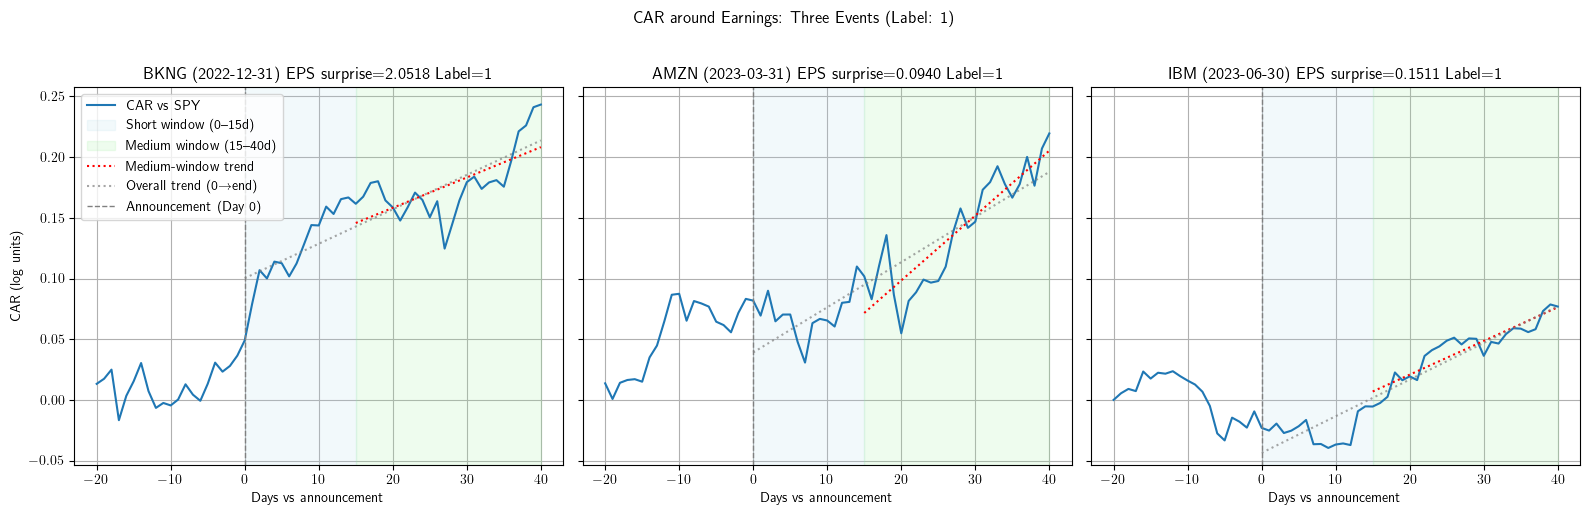

Saved: Plots/PEAD_demo/triptych_pos_label0.png


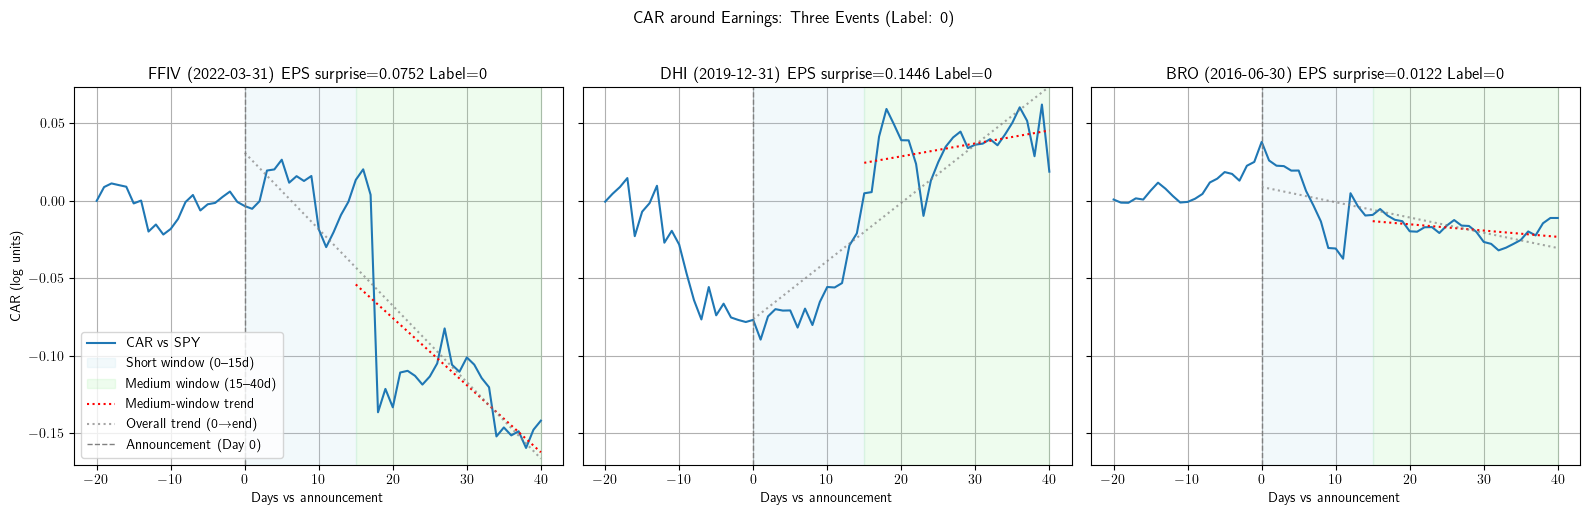

Saved: Plots/PEAD_demo/triptych_neg_eps.png


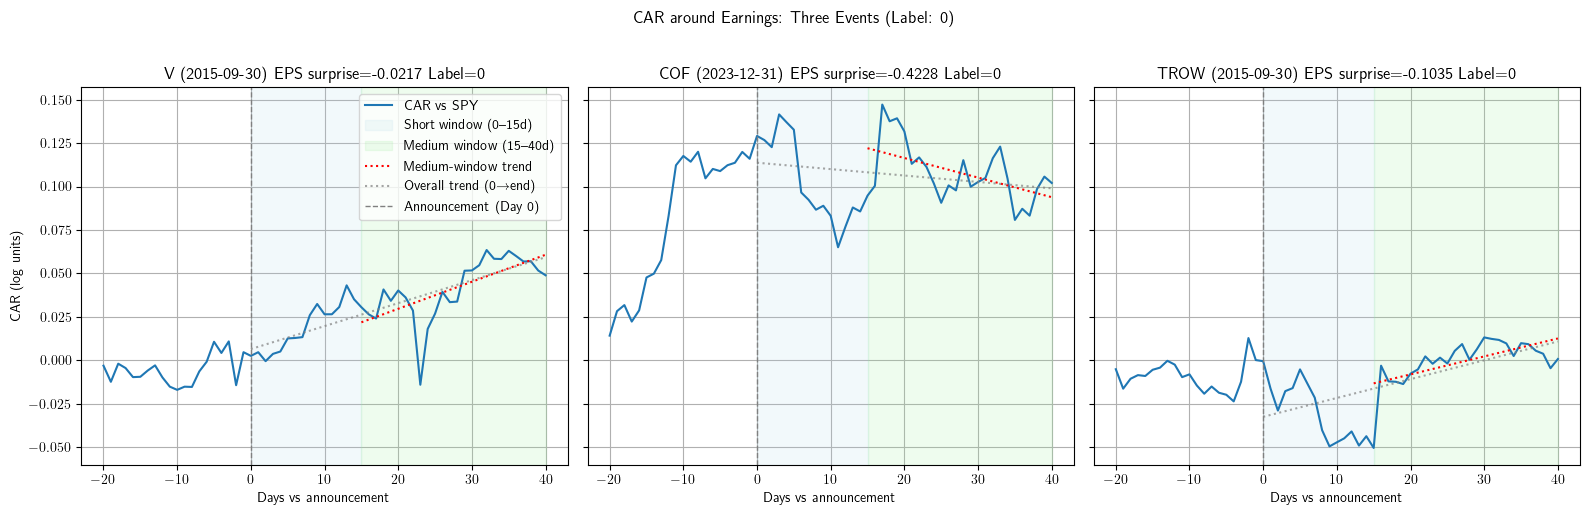

In [48]:
_ = plot_three_triptychs_from_subgraphs(subgraphs, post_event_days=40)


In [62]:
def count_subgraph_categories(subgraphs:List[SubGraph], required_graph_counts:int = 10) -> dict:
    """
    Count subgraph instances by given conditions:
    1. Label = 1, EPS positive
    2. Label = 0, EPS negative
    3. EPS negative (any label)
    """
    
    cat1 = 0  # Label = 1, EPS positive
    cat2 = 0  # Label = 0, EPS negative
    cat3 = 0  # EPS negative (any label)
    total = 0
    all_graphs = len(subgraphs)

    for sg in subgraphs:
        if sg.fact_count < required_graph_counts:
            continue
        total += 1
        eps = sg.eps_surprise
        label = sg.label

        if eps is None or label is None:
            continue  # skip incomplete entries

        if label == 1 and eps > 0:
            cat1 += 1
        if label == 0 and eps > 0:
            cat2 += 1
        if eps < 0:
            cat3 += 1

    return {
        "Total graphs processed": all_graphs,
        "Subgraphs with sufficient facts": total,
        "Label=1, EPS positive": cat1,
        "Label=0, EPS positive": cat2,
        "EPS negative (any label)": cat3
    }

# Example usage
counts = count_subgraph_categories(subgraphs)
for k, v in counts.items():
    print(f"{k}: {v}")


Total graphs processed: 5888
Subgraphs with sufficient facts: 2896
Label=1, EPS positive: 606
Label=0, EPS positive: 1571
EPS negative (any label): 715
